## Initialising model and libraries

In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D
from fit.utils.utils import denormalize, denormalize_amp, denormalize_phi

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy
seed_everything(22122020)
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32,subset_flag = False)
dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells =5,
                              model_type = 'mamba')


#Transformers
# trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Fast_prod__L_8_H_8_s_5_subset_False_27-03_16-58-36/epoch=222-step=383337.ckpt'
#ProdLoss
trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Mamba_prod_W_phi_100_L_8_H_8_s_5_subset_False_04-04_17-02-10/epoch=506-step=871533.ckpt'
#SumLoss
# trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Mamba_sum_W_phi_100_L_8_H_8_s_5_subset_False_04-04_17-02-10/epoch=61-step=106578.ckpt'

weights = torch.load(trained_model_path)['state_dict']
model.load_state_dict(weights, strict=False)
model.cuda()
model.eval()

trainer = Trainer(max_epochs=100, 
                #gpus=1, # set to 0 if you want to run on CPU
                callbacks=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            mode='min'
                                        ), 
                deterministic=True)



/localscratch/miniforge3/envs/SSM_Home/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020


Using Full MNIST dataset


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/localscratch/miniforge3/envs/SSM_Home/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


### Loading DataModule and predicting using inference and forward function both

In [2]:
for fc, (mag_min, mag_max) in dm.train_dataloader():
    break

fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
low_res = fc[:, flatten_order][:, :model.input_seq_length]
x_fc = fc[:, flatten_order][:, :-1]
y_fc = fc[:, flatten_order][:, 1:]
gt = fc[:, flatten_order]



In [3]:
pred_inference = model.sres.forward_inference(low_res)
pred_forward = gt.clone()
pred_forward[:,1:] = model.sres.forward(x_fc); 

torch.Size([378, 2])


### In Prediction Per Token Absolute Deviation from Ground Truth

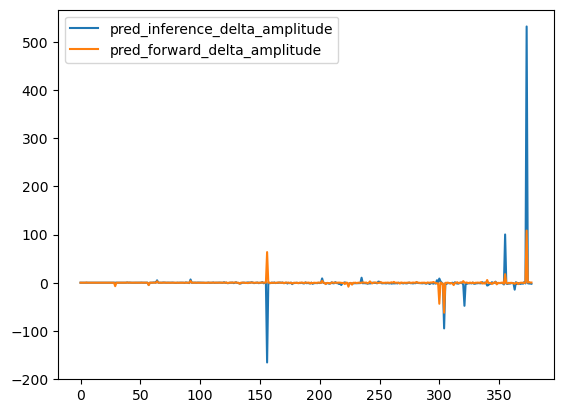

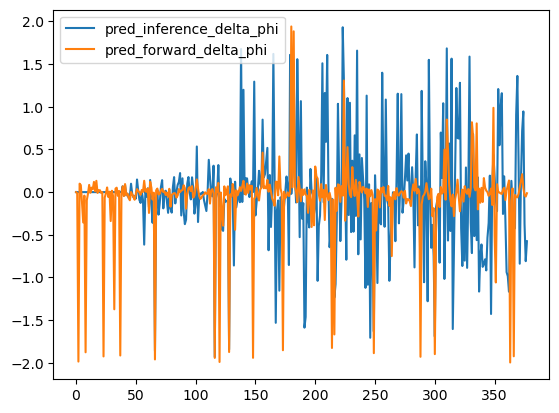

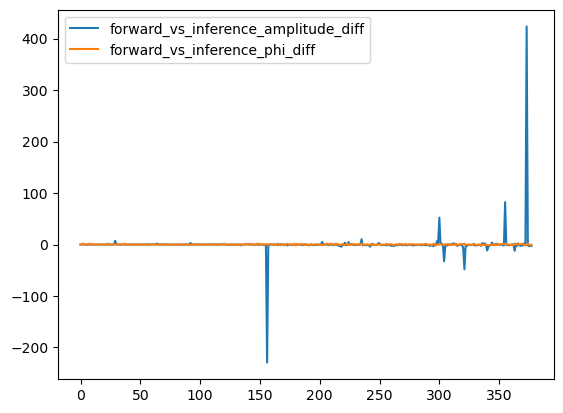

In [4]:
a1 = (pred_inference[0]-gt[0])[:,0][:]/(gt[0][:,0][:])
a2 = (pred_forward[0]-gt[0])[:,0][:]/(gt[0][:,0][:])
a1 = a1.detach().cpu().numpy()
a2 = a2.detach().cpu().numpy()
b1 = (pred_inference[0]-gt[0])[:,1][:]
b2 = (pred_forward[0]-gt[0])[:,1][:]
b1 = b1.detach().cpu().numpy()
b2 = b2.detach().cpu().numpy()
plt.figure()
start = 0
end = 378
plt.plot([i for i in range(start,end)],a1[start:end],label = 'pred_inference_delta_amplitude')
plt.plot([i for i in range(start,end)],a2[start:end],label = 'pred_forward_delta_amplitude')
plt.legend();plt.show()
plt.figure()
plt.plot([i for i in range(start,end)],b1[start:end],label = 'pred_inference_delta_phi')
plt.plot([i for i in range(start,end)],b2[start:end],label = 'pred_forward_delta_phi')
plt.legend();plt.show()
plt.figure()
plt.plot([x for x in range(start,len(a1))],(a1-a2)[start:],label = 'forward_vs_inference_amplitude_diff')
plt.plot([x for x in range(start,end)],(b1-b2)[start:end],label = 'forward_vs_inference_phi_diff')
plt.legend()
plt.show()

### Masked

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([378, 2])


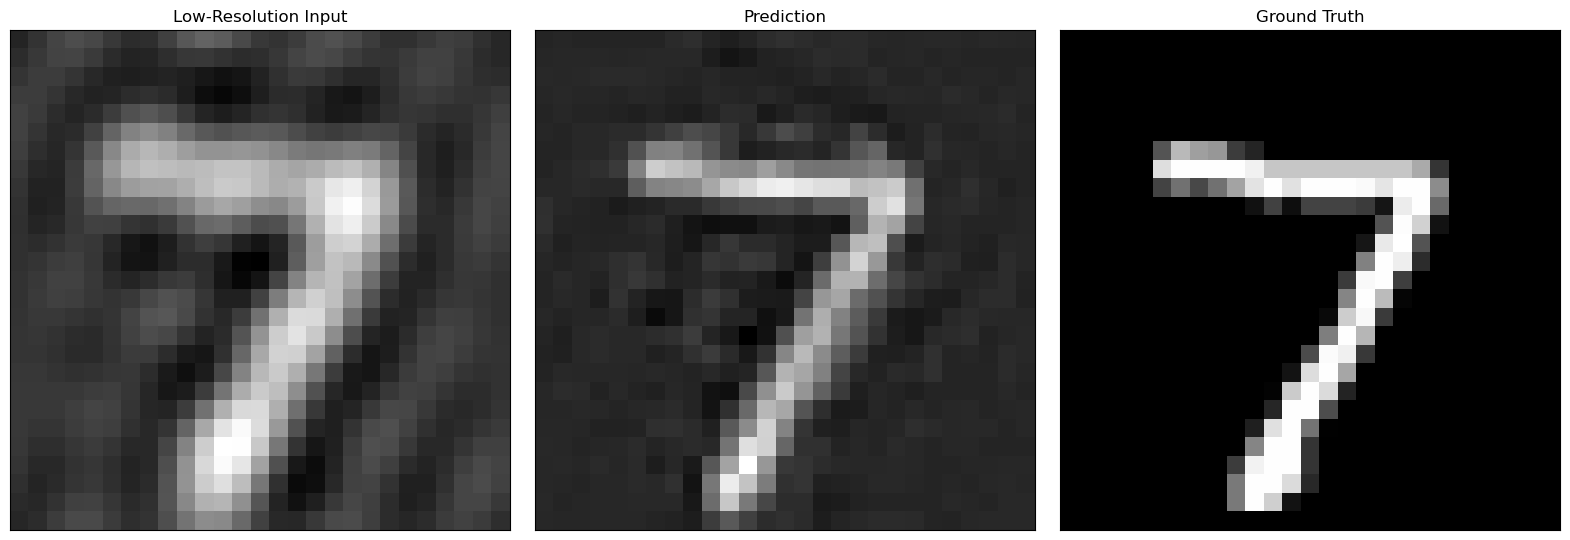

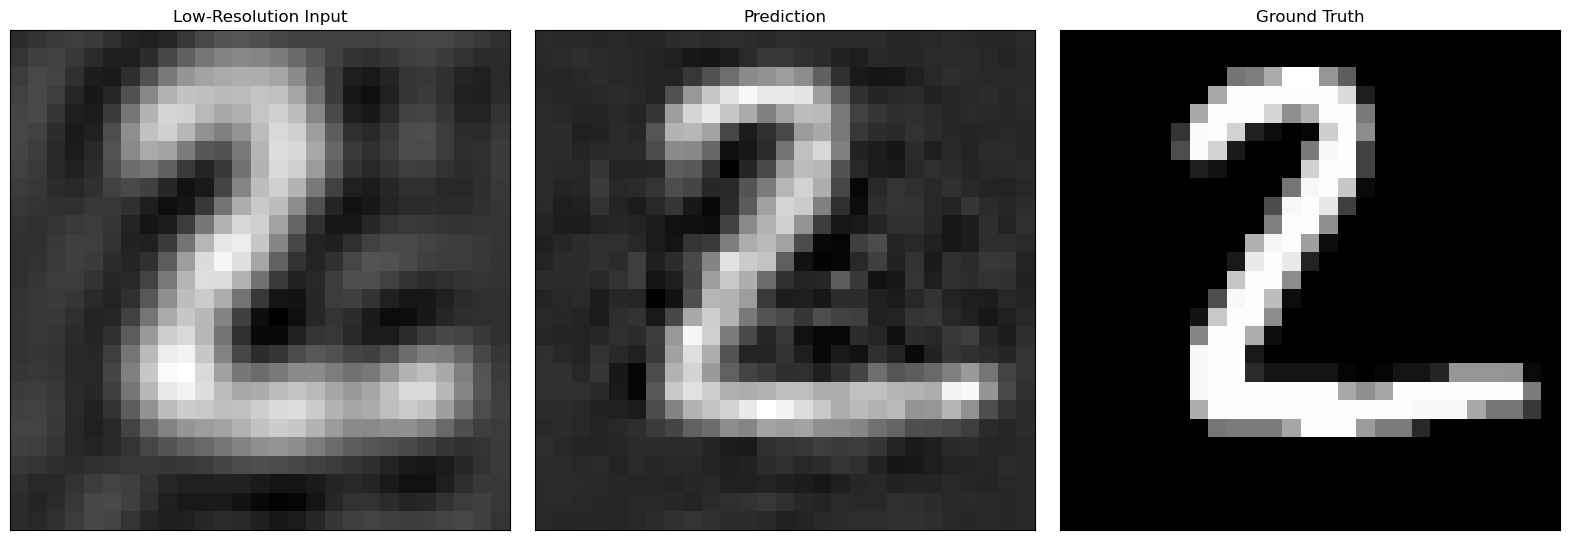

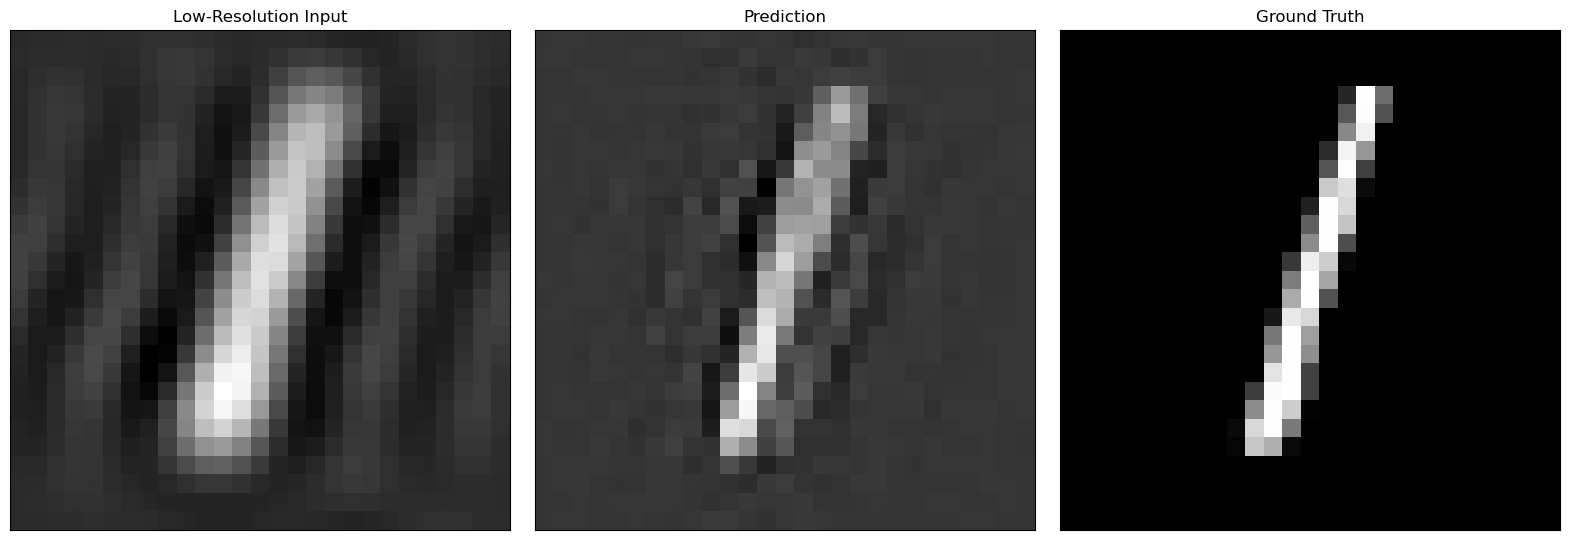

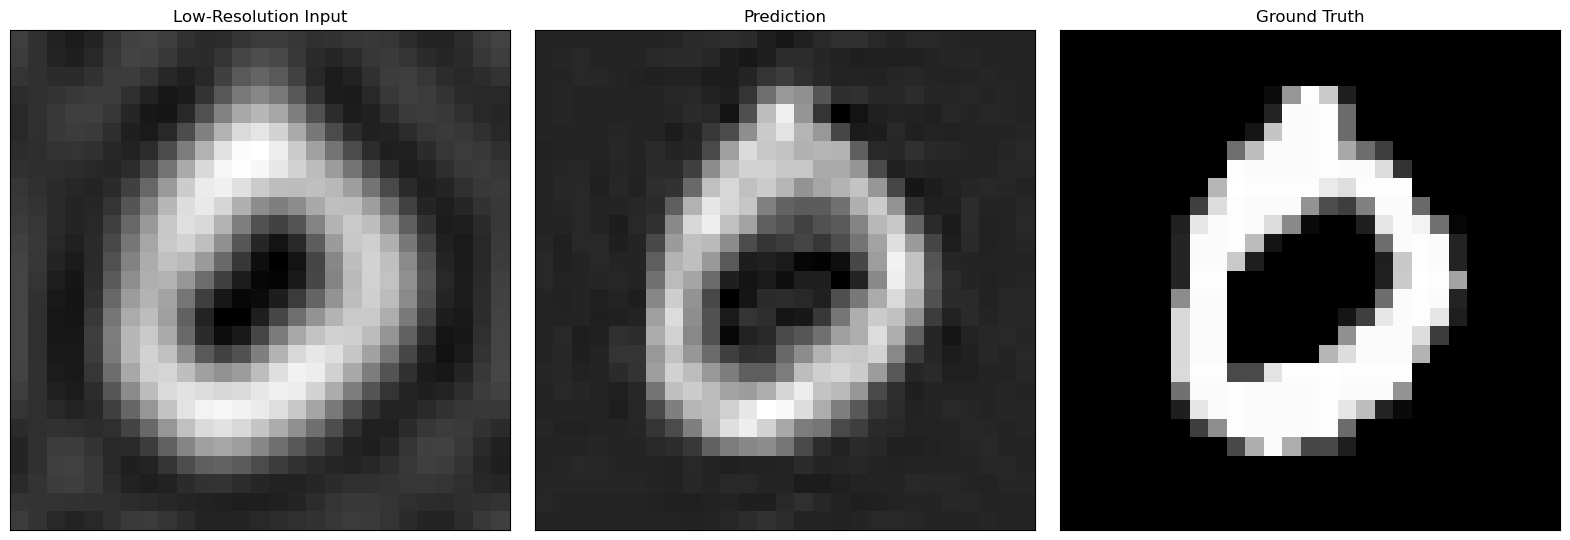

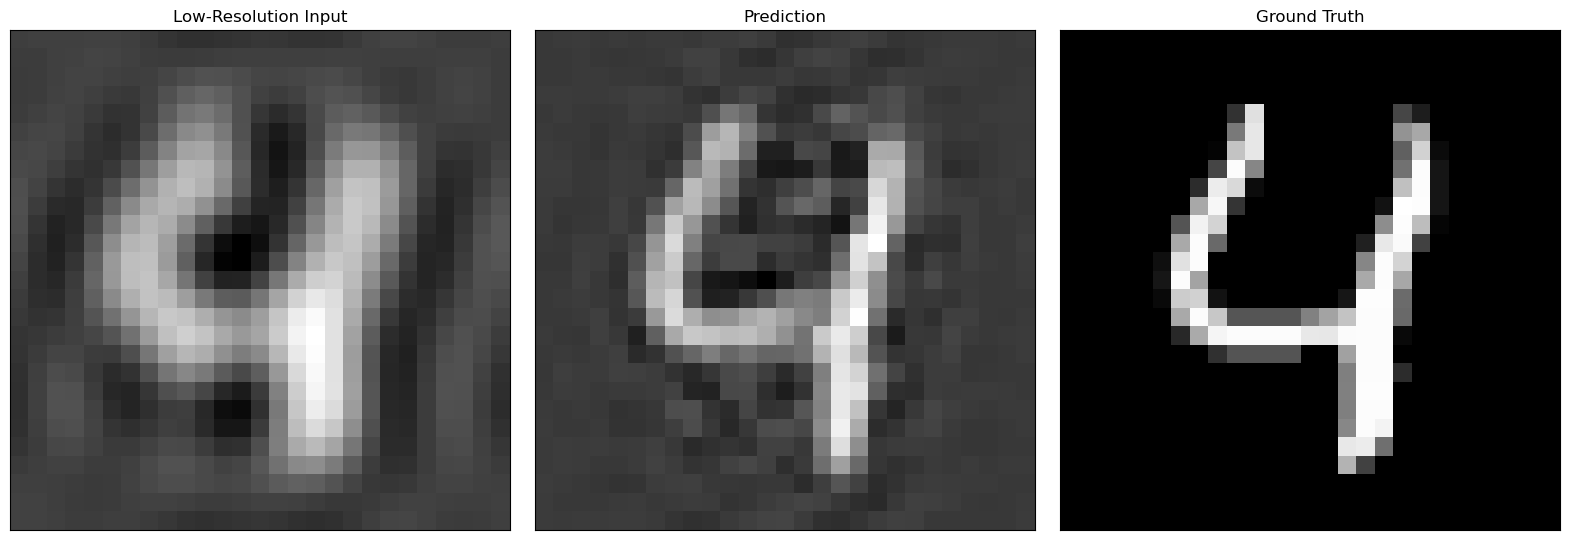

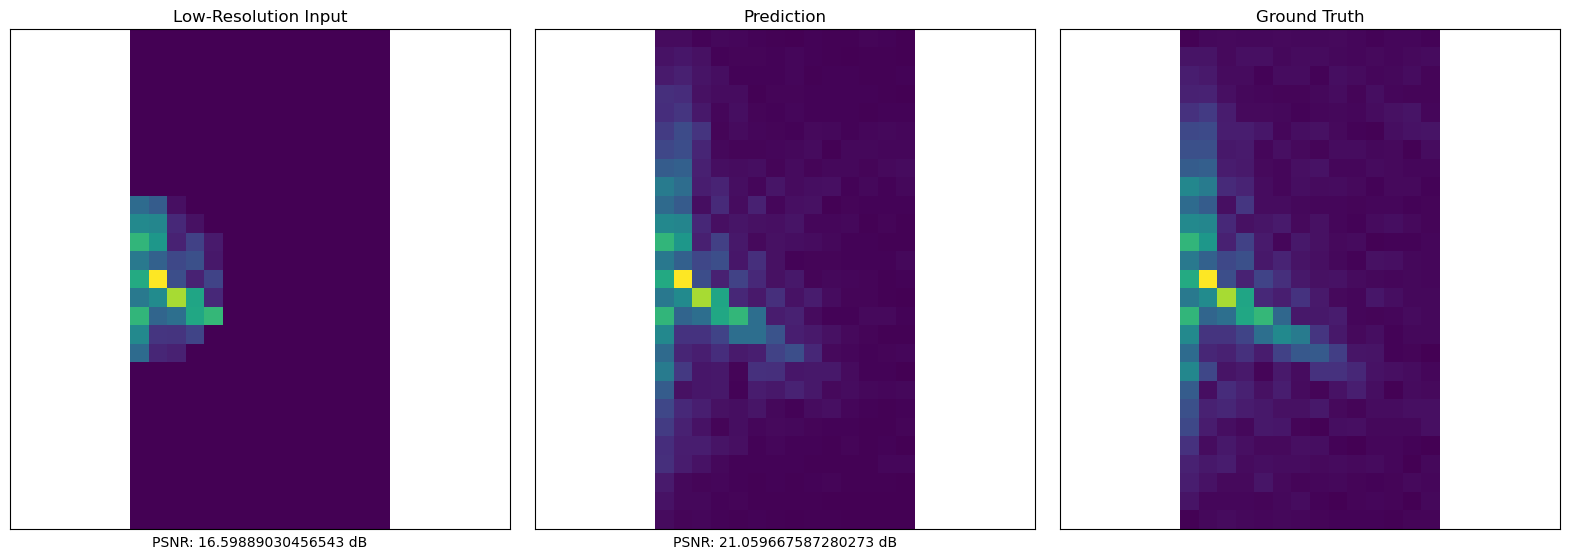

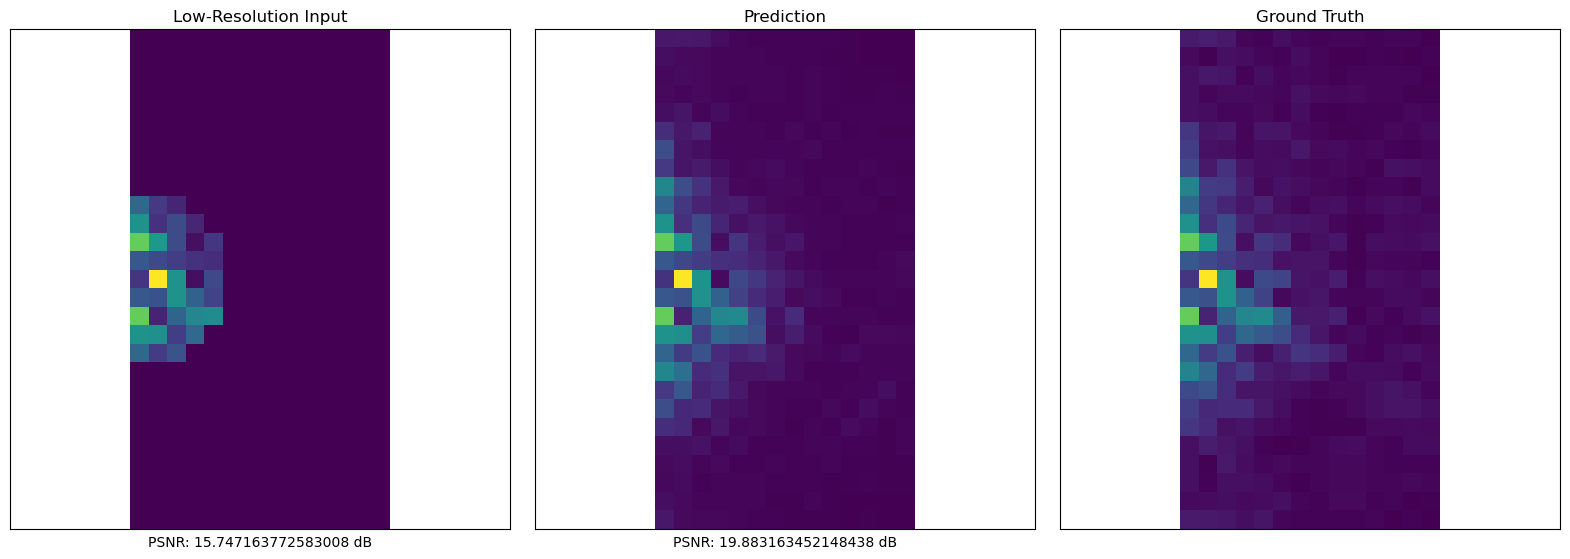

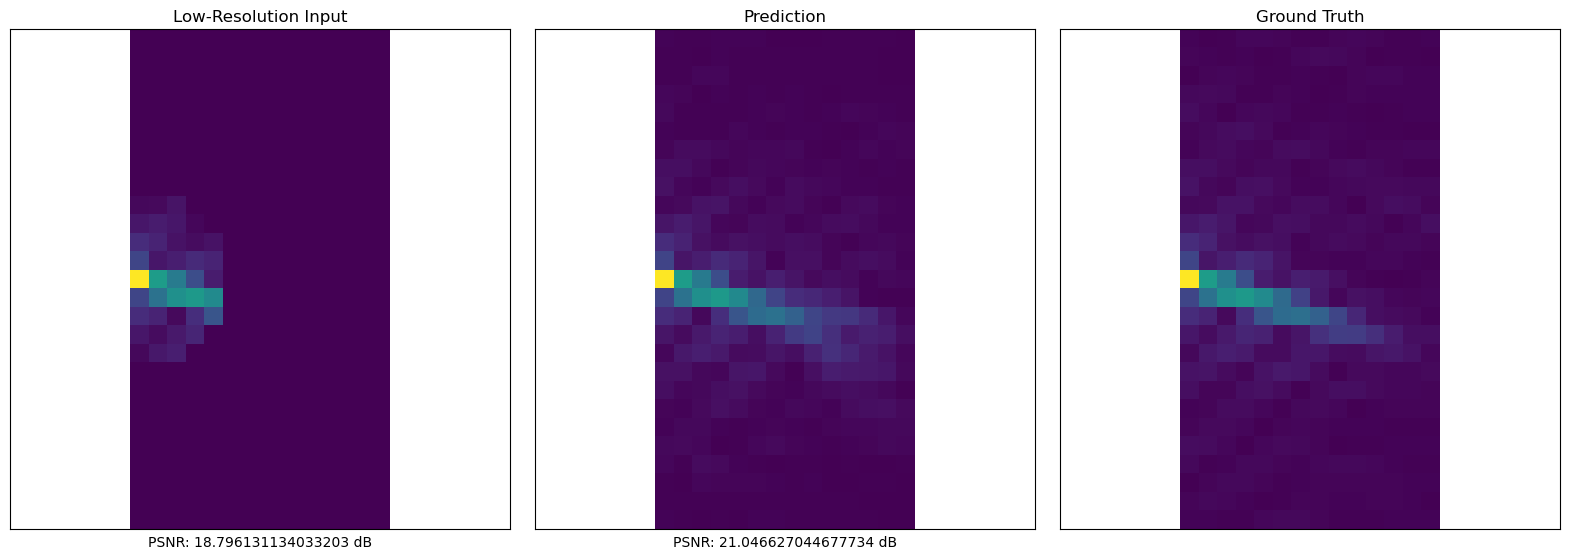

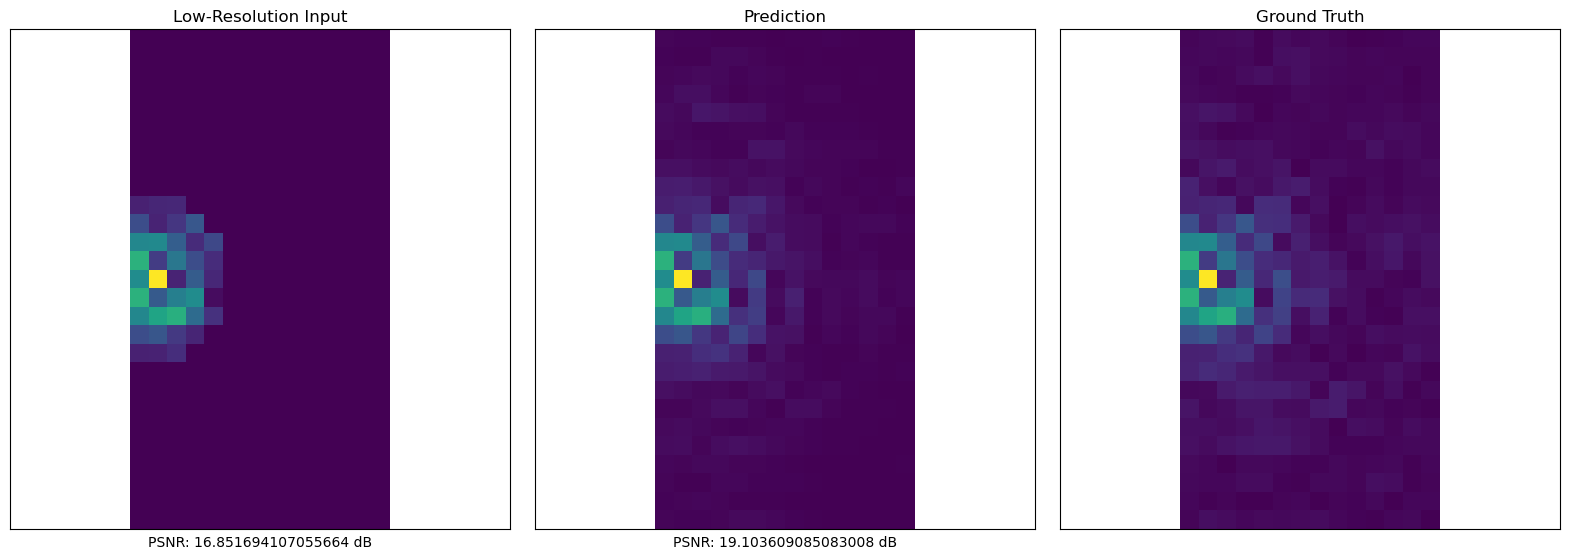

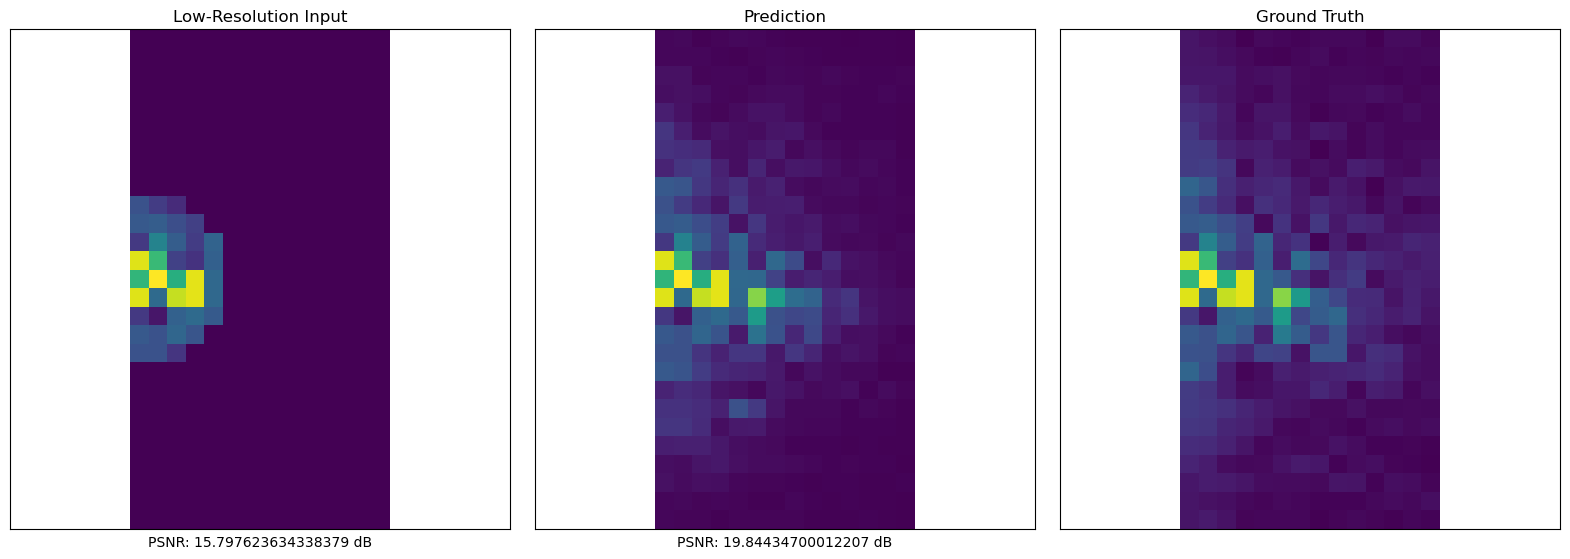

In [5]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
low_res = fc[:, flatten_order][:, :model.input_seq_length]
x_fc = fc[:, flatten_order][:, :-1]
y_fc = fc[:, flatten_order][:, 1:]
gt = fc[:, flatten_order]

with torch.no_grad():
    pred = model.sres.forward_inference(low_res)

# pred[:,:,1] = gt[:,:,1]
fig = plt.figure()

lowres = torch.zeros_like(pred)
lowres+=fc.min()
lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)     
lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)


lowres_psnr = PSNR(gt_img,lowres_img)
pred_psnr = PSNR(gt_img,pred_img)


sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
fig.legend()
plt.savefig('psnr_diff.png')
plt.close()
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()
for sample in range(5):
    fig2 = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

from sklearn.random_projection import sample_without_replacement


diff = []
for i in range(5):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)
    

In [7]:
lowres = torch.load('../inference_results/lowres.pt').cpu()
pred = torch.load('../inference_results/pred.pt').cpu()
mamba_lowres = torch.load('../inference_results/mamba_lowres.pt').cpu()
mamba_pred = torch.load('../inference_results/mamba_pred.pt').cpu()



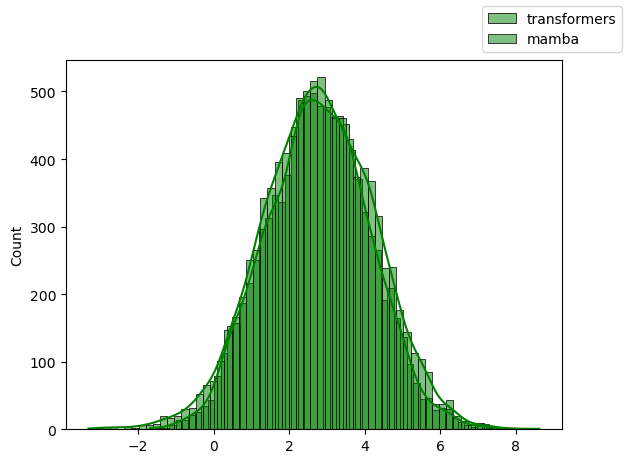

In [8]:
fig = plt.figure()
sns.histplot(pred.cpu().detach() - lowres.cpu().detach(), kde=True, color='green', legend= True, label = "transformers")
sns.histplot(mamba_pred.cpu().detach() - mamba_lowres.cpu().detach(), kde=True, color='green', legend= True, label = "mamba")
fig.legend()
# plt.savefig('./inference_results/mamba_psnr_diff.png')
